In [1]:
#***********************************************************************************************#
# Implementación del circuito de Teletransportación Cuántica en la plataforma Qiskit de IBM.
#***********************************************************************************************#

#***********************************************************************************************#
# Para esta implementación se ha tenido en cuenta la descripción del circuito dada en el siguiente 
# tutorial del libro de Qiskit:
# https://qiskit.org/textbook/ch-algorithms/teleportation.html

# Además se han tomando instrucciones e ideas del tutorial de la comunidad de desarrolladores de Qiskit disponible en:
# https://github.com/Qiskit/qiskit-community-tutorials/blob/master/terra/qis_intro/teleportation_superdensecoding.ipynb
#***********************************************************************************************#

#***********************************************************************************************#
# Curso de Computación Cuántica
# Prof. Gustavo Patino
# Departamento de Ingeniería Electrónica y Telecomunicaciones
# Facultad de Ingeniería
# Universidad de Antioquia
# Medellin, 2020-2023
#***********************************************************************************************#

In [2]:
# Ejecución en un Computador Cuántico real

In [3]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [4]:
from qiskit_textbook.tools import random_state, vector2latex
from qiskit.extensions import Initialize

In [5]:
from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit.tools.monitor import job_monitor

In [6]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
# %config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [7]:
# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica

In [8]:
def crear_estado_bell00(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

In [9]:
def alice_circuit(qc, q2send, beta0):
    qc.cx(q2send, beta0)
    qc.h(q2send)

In [10]:
def alice_mide(qc, a, b):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)
    qc.barrier()
    qc.barrier()

In [11]:
# def bob_circuit(qc, beta1, m1, m2):
#     qc.z(beta1).c_if(m1, 1)
#     qc.x(beta1).c_if(m2, 1)

In [12]:
def bob_circuit(qc, q0, q1, beta1):
    qc.cz(q0, beta1)
    qc.cx(q1, beta1)

In [13]:
# Definición del circuito de teletransportación cuántica sin medidas de Alice

In [14]:
qr = QuantumRegister(3)
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)
crbob = ClassicalRegister(1)

teleport_cir_real = QuantumCircuit(qr, crz, crx, crbob)

qrandom = random_state(1)
vector2latex(qrandom, pretext="|\\psi\\rangle =")

init_gate =Initialize(qrandom)

teleport_cir_real.append(init_gate, [0])
teleport_cir_real.barrier()

crear_estado_bell00(teleport_cir_real, qr[1], qr[2])
teleport_cir_real.barrier()

alice_circuit(teleport_cir_real, qr[0], qr[1])
teleport_cir_real.barrier()

bob_circuit(teleport_cir_real, qr[0], qr[1], qr[2])
teleport_cir_real.barrier()
teleport_cir_real.measure(qr[0], crz)
teleport_cir_real.measure(qr[1], crx)
teleport_cir_real.measure(qr[2], crbob)

<IPython.core.display.Math object>

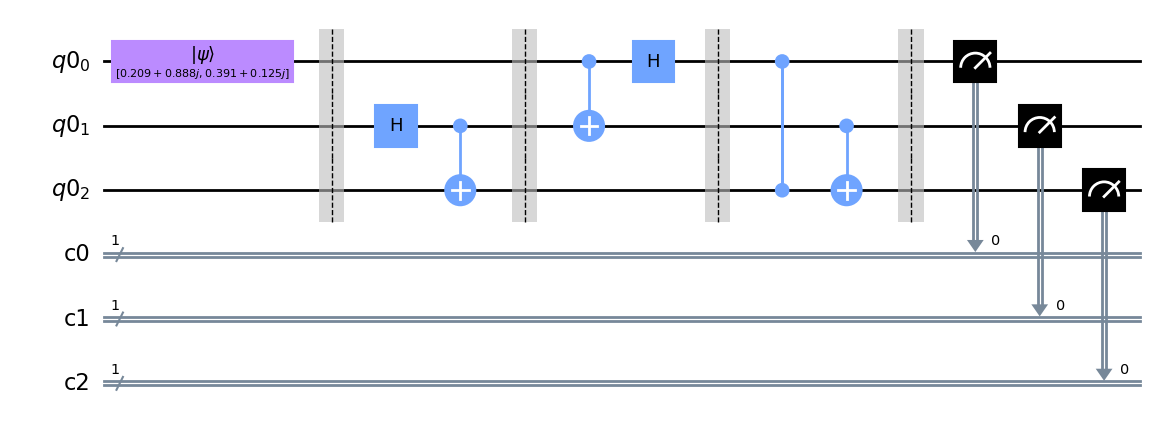

In [15]:
teleport_cir_real.draw('mpl')

In [16]:
local_backend = Aer.get_backend('qasm_simulator') # note that this circuit can not be run on an IBM Q device
teleport_job = execute(teleport_cir_real, local_backend, shots=1024) 
teleport_result = teleport_job.result()

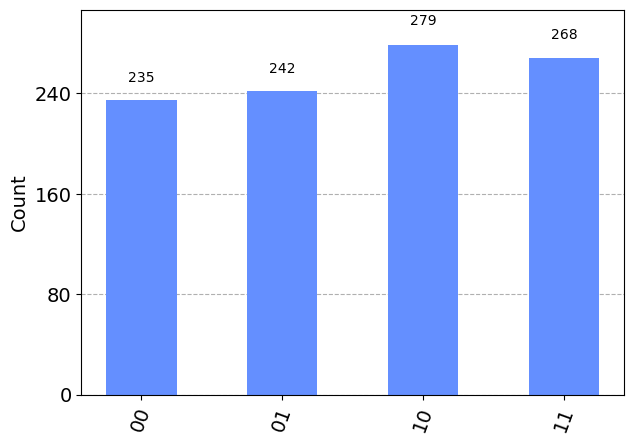

In [17]:
data = teleport_result.get_counts(teleport_cir_real)
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice)

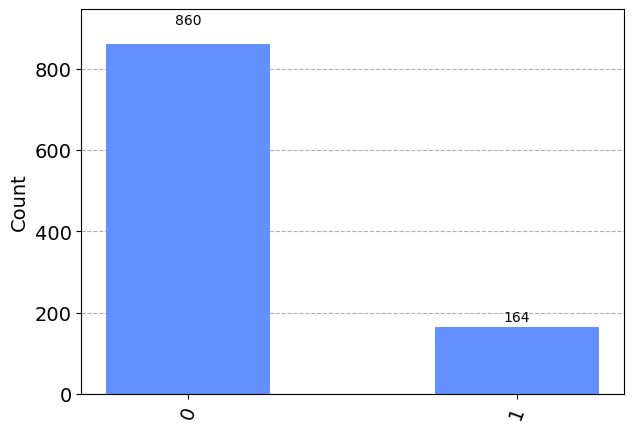

In [18]:
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob)

In [19]:
provider = IBMProvider(instance="ibm-q-education/uni-antioquia-2/quantum-alg")

In [20]:
remote_backend = least_busy(provider.backends(filters=lambda procesador_cuantico: procesador_cuantico.configuration().n_qubits >= 3 
                                       and not procesador_cuantico.configuration().simulator 
                                       and procesador_cuantico.status().operational==True))
print("El procesador cuántico menos ocupado es el " + remote_backend.name)

El procesador cuántico menos ocupado es el ibm_nairobi


In [21]:
job_exp = execute(teleport_cir_real, remote_backend, shots=8192)
job_monitor(job_exp)

#JOB-ID = ch0p8bhpiqvdaaildvc0

Job Status: job has successfully run


In [22]:
job_exp_result = job_exp.result()

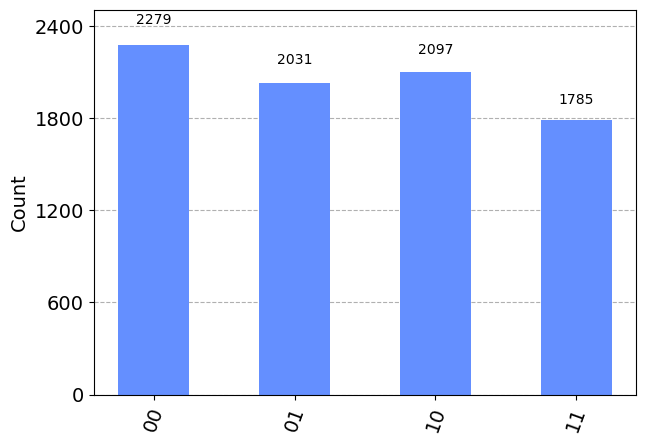

In [23]:
data = job_exp_result.get_counts(teleport_cir_real)
alice_real = {}
alice_real['00'] = data['0 0 0'] + data['1 0 0']
alice_real['10'] = data['0 1 0'] + data['1 1 0']
alice_real['01'] = data['0 0 1'] + data['1 0 1']
alice_real['11'] = data['0 1 1'] + data['1 1 1']
plot_histogram(alice_real)

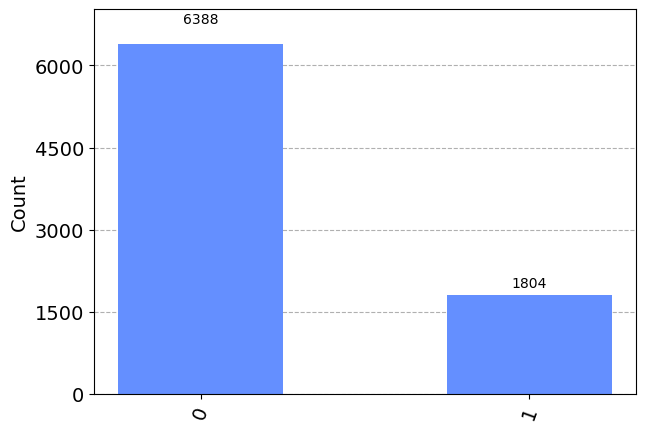

In [24]:
bob_real = {}
bob_real['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob_real['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']
plot_histogram(bob_real)

In [25]:
bob_sim_1 = sum([bob[result] for result in bob.keys() if result[0]=='1'])/sum(list(bob.values()))
print(bob_sim_1)

bob_real_1 = sum([bob_real[result] for result in bob_real.keys() if result[0]=='1'])/sum(list(bob_real.values()))
print(bob_real_1)

error_rate_percent =(abs(bob_real_1 - bob_sim_1)/bob_sim_1)*100
print("La tasa de error experimental fue del: ", error_rate_percent, "%")

0.16015625
0.22021484375
La tasa de error experimental fue del:  37.5 %


In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright